In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#%cd /content/drive/MyDrive/AI-Medic/Projects/P4
%cd /content/drive/MyDrive/P4

/content/drive/.shortcut-targets-by-id/13zYMwPj9a8yYFyjit1V6DDxVOCZCQHHY/P4


In [ ]:
!wget https://warwick.ac.uk/fac/cross_fac/tia/data/hovernet/consep.zip

In [ ]:
!unzip "consep.zip"

In [ ]:
!pip install segmentation_models

     |████████████████████████████████| 50 kB 4.3 MB/s 


In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import scipy.io
from sklearn.metrics import confusion_matrix

import segmentation_models as sm
sm.set_framework('tf.keras')
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.optimizers import Adam

%load_ext tensorboard

Segmentation Models: using `keras` framework.


# Load Data

In [ ]:
image_size = 512

In [ ]:
X_train = []
Y_train = []

for i in range(1,28):
  img = cv2.imread(os.path.join('CoNSeP/Train/Images',f'train_{i}.png'))
  img = cv2.resize(img, (image_size, image_size)) 
  mat = scipy.io.loadmat(os.path.join('CoNSeP/Train/Labels',f'train_{i}.mat'))
  Y_train.append(mat['type_map'])
  X_train.append(img)

X_train = np.array(X_train)
Y_train = np.array(Y_train)
Y_train_temp = np.zeros((Y_train.shape[0], image_size, image_size))
for i in range(Y_train.shape[0]):
  Y_train_temp[i] = cv2.resize(Y_train[i], (image_size, image_size), interpolation=cv2.INTER_NEAREST)
Y_train = Y_train_temp.copy()

In [ ]:
image_shape = X_train.shape[1:]
num_classes = 8

In [ ]:
print(X_train.shape)
print(Y_train.shape)
print(image_shape)

(27, 512, 512, 3)
(27, 512, 512)
(512, 512, 3)


In [ ]:
X_train = X_train / 255.

Y_train = to_categorical(Y_train, num_classes=num_classes)

# Train model

In [ ]:
model = sm.Unet(backbone_name='vgg16',
                input_shape=image_shape,
                classes=num_classes,
                activation='softmax',
                encoder_weights='imagenet'
                )

In [ ]:
total_loss = sm.losses.categorical_focal_dice_loss
metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

model.compile(
    optimizer=Adam(0.001),
    loss=total_loss,
    metrics=metrics,
)

In [ ]:
history = model.fit(
   x=X_train,
   y=Y_train,
   batch_size=4,
   epochs=15,
   validation_split=0.15
   )

Epoch 1/15
6/6 [==============================] - 7s 879ms/step - loss: 1.1947 - iou_score: 0.0848 - f1-score: 0.1003 - val_loss: 1.0037 - val_iou_score: 0.1205 - val_f1-score: 0.1427
Epoch 2/15
6/6 [==============================] - 5s 773ms/step - loss: 0.9828 - iou_score: 0.1703 - f1-score: 0.1924 - val_loss: 0.9236 - val_iou_score: 0.1755 - val_f1-score: 0.1843
Epoch 3/15
6/6 [==============================] - 5s 858ms/step - loss: 0.9363 - iou_score: 0.1891 - f1-score: 0.2074 - val_loss: 0.9114 - val_iou_score: 0.1778 - val_f1-score: 0.1894
Epoch 4/15
6/6 [==============================] - 4s 763ms/step - loss: 0.9247 - iou_score: 0.1692 - f1-score: 0.1918 - val_loss: 0.9018 - val_iou_score: 0.1771 - val_f1-score: 0.1939
Epoch 5/15
6/6 [==============================] - 5s 771ms/step - loss: 0.9193 - iou_score: 0.1701 - f1-score: 0.1978 - val_loss: 0.9008 - val_iou_score: 0.1779 - val_f1-score: 0.1948
Epoch 6/15
6/6 [==============================] - 5s 861ms/step - loss: 0.9127 -

In [ ]:
callbacks = [
             ModelCheckpoint('UNet_VGG16_finetune.hdf5', save_best_only=True, verbose=1, monitor='val_iou_score', mode='max'),
             ReduceLROnPlateau(monitor='val_loss', factor=0.6, patience=7, verbose=1, min_lr=0.0001),
             TensorBoard('logs', histogram_freq=1, update_freq='epoch')
            ]

In [ ]:
total_loss = sm.losses.categorical_focal_dice_loss
metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

model.compile(
    optimizer=Adam(0.001),
    loss=total_loss,
    metrics=metrics,
)

In [ ]:
%tensorboard --logdir logs

In [ ]:
history = model.fit(
   x=X_train,
   y=Y_train,
   batch_size=4,
   epochs=50,
   validation_split=0.15,
   callbacks=callbacks
   )

Epoch 1/50
6/6 [==============================] - 27s 3s/step - loss: 0.9682 - iou_score: 0.0524 - f1-score: 0.0757 - val_loss: 1.4773 - val_iou_score: 0.1890 - val_f1-score: 0.1905

Epoch 00001: val_iou_score improved from -inf to 0.18901, saving model to UNet_VGG16_finetune.hdf5
Epoch 2/50
6/6 [==============================] - 10s 2s/step - loss: 0.9083 - iou_score: 0.1524 - f1-score: 0.1904 - val_loss: 1.4887 - val_iou_score: 0.1890 - val_f1-score: 0.1904

Epoch 00002: val_iou_score did not improve from 0.18901
Epoch 3/50
6/6 [==============================] - 10s 2s/step - loss: 0.8614 - iou_score: 0.1658 - f1-score: 0.2145 - val_loss: 1.4884 - val_iou_score: 0.1890 - val_f1-score: 0.1904

Epoch 00003: val_iou_score did not improve from 0.18901
Epoch 4/50
6/6 [==============================] - 10s 2s/step - loss: 0.8400 - iou_score: 0.2297 - f1-score: 0.2749 - val_loss: 1.4878 - val_iou_score: 0.1890 - val_f1-score: 0.1905

Epoch 00004: val_iou_score improved from 0.18901 to 0.189

# Evaluation

In [ ]:
image_size = 512

In [ ]:
X_test = []
Y_test = []

for i in range(1,15):
  img = cv2.imread(os.path.join('CoNSeP/Test/Images',f'test_{i}.png'))
  img = cv2.resize(img, (image_size, image_size))
  mat = scipy.io.loadmat(os.path.join('CoNSeP/Test/Labels',f'test_{i}.mat'))
  Y_test.append(mat['type_map'])
  X_test.append(img)

X_test = np.array(X_test)
Y_test = np.array(Y_test)
Y_test_temp = np.zeros((Y_test.shape[0], image_size, image_size))
for i in range(Y_test.shape[0]):
  Y_test_temp[i] = cv2.resize(Y_test[i], (image_size, image_size), interpolation=cv2.INTER_NEAREST)
Y_test = Y_test_temp.copy()

In [ ]:
num_classes = 8
image_shape = X_test.shape[1:]
X_test = X_test / 255.

Y_test = to_categorical(Y_test, num_classes=num_classes)

In [ ]:
model = sm.Unet(backbone_name='vgg16',
                input_shape=image_shape,
                classes=num_classes,
                activation='softmax',
                encoder_weights='imagenet'
                )

total_loss = sm.losses.categorical_focal_dice_loss
metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]
model.compile(
    optimizer=Adam(0.001),
    loss=total_loss,
    metrics=metrics,
)

model.load_weights('UNet_VGG16_finetune.hdf5')

In [ ]:
scores = model.evaluate(X_test, Y_test, batch_size=1)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

14/14 [==============================] - 35s 186ms/step - loss: 0.7728 - iou_score: 0.4374 - f1-score: 0.4839
Loss: 0.77276
mean iou_score: 0.43739
mean f1-score: 0.48385


In [ ]:
Y_pred = model.predict(X_test, batch_size=1)

In [ ]:
Y_pred = Y_pred.argmax(axis=3)

In [ ]:
Y_test= Y_test.argmax(axis=3)

In [ ]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap, aspect='auto')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    np.set_printoptions(suppress=True, precision=3)
    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, np.round(cm[i, j],2),
            horizontalalignment="center",
            color="black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


EPS = 1e-12
def get_iou(gt, pr, n_classes):
    class_wise = np.zeros(n_classes)
    for cl in range(n_classes):
        intersection = np.sum((gt == cl)*(pr == cl))
        union = np.sum(np.maximum((gt == cl), (pr == cl)))
        iou = float(intersection)/(union + EPS)
        class_wise[cl] = iou
    return class_wise

def get_dice(Y_test, Y_pred, num_class):

  total_dice = np.zeros((num_class,))

  for i in range(num_class):
    for j in range(Y_test.shape[0]):
      total_dice[i] += (2 * np.sum(Y_pred[j][Y_test[j] == i] == i)) / (np.sum(Y_pred[j] == i) + np.sum(Y_test[j] == i))
    if np.isnan(total_dice[i]):
      total_dice[i] = 0
  total_dice = (total_dice / Y_test.shape[0]).astype(float)

  return total_dice

In [ ]:
all_iou = get_iou(Y_test, Y_pred, 8)
for i in range(8):
  print(f'mean iou for class{i}: ', float(all_iou[i]))

mean iou for class0:  0.8854016878701673
mean iou for class1:  0.03320747850611836
mean iou for class2:  0.4346016646848989
mean iou for class3:  0.0014270424545130217
mean iou for class4:  0.4890546343144073
mean iou for class5:  0.2666537575276417
mean iou for class6:  0.03557870440671789
mean iou for class7:  0.0


In [ ]:
all_dice = get_dice(Y_test, Y_pred, 8)
for i in range(8):
  print(f'mean dice for class{i}: ', all_dice[i])

mean dice for class0:  0.9370425075759649
mean dice for class1:  0.03422507202668333
mean dice for class2:  0.4729889661320823
mean dice for class3:  0.00037427323824498613
mean dice for class4:  0.3546629957611464
mean dice for class5:  0.34036568252131694
mean dice for class6:  0.018355023546610505
mean dice for class7:  0.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in long_scalars


In [ ]:
idx = 3

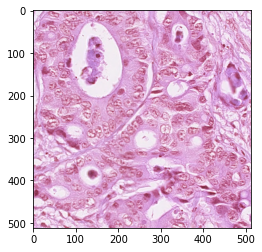

In [ ]:
plt.imshow(X_test[idx])

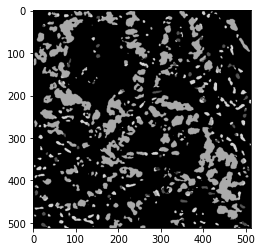

In [ ]:
plt.imshow(Y_pred[idx], cmap='gray')

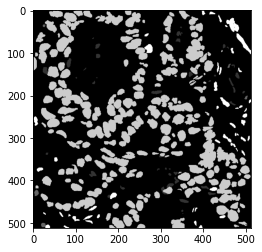

In [ ]:
#plt.imshow(Y_test[idx].argmax(axis=2))
plt.imshow(Y_test[idx], cmap='gray')

In [ ]:
Y_pred = Y_pred.reshape((14,-1))
Y_test = Y_test.reshape((14,-1))

In [ ]:
from sklearn.metrics import accuracy_score

temp=0
for i in range(14):
  temp += accuracy_score(Y_pred[i], Y_test[i])
print('Mean Accuracy score: ', temp/14)

Mean Accuracy score:  0.8627172197614398


Normalized confusion matrix
[[0.954 0.    0.003 0.    0.028 0.012 0.002 0.   ]
 [0.362 0.038 0.283 0.    0.034 0.266 0.017 0.   ]
 [0.168 0.003 0.634 0.001 0.005 0.185 0.005 0.   ]
 [0.218 0.004 0.042 0.001 0.683 0.049 0.001 0.   ]
 [0.253 0.002 0.015 0.002 0.684 0.043 0.001 0.   ]
 [0.428 0.006 0.069 0.001 0.059 0.406 0.032 0.   ]
 [0.678 0.    0.015 0.    0.006 0.256 0.045 0.   ]
 [0.404 0.005 0.033 0.    0.03  0.492 0.036 0.   ]]


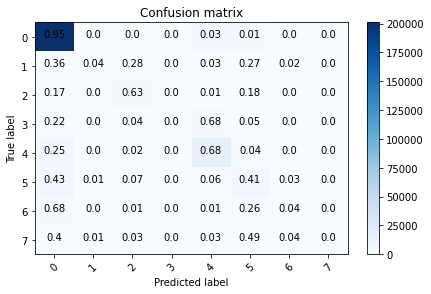

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools

total_cm = np.zeros((8,8)).astype(float)
for i in range(14):
  cm = confusion_matrix(y_true=Y_test[i], y_pred=Y_pred[i])
  for i in range(8):
    for j in range(8):
      try:
        total_cm[i][j] += cm[i][j]
      except:
        pass

total_cm = total_cm / 14
total_cm = total_cm.astype(int)
label_names = ['0', '1', '2', '3', '4', '5', '6', '7']

plot_confusion_matrix(cm=total_cm, classes=label_names, normalize=True)
#plot_confusion_matrix(cm=total_cm, classes=label_names)

# preprocessing
I couldn't train the model on this beacause i didn't have any GPU Left :)

In [ ]:
from tqdm import tqdm
import random

def Preprocessing(x_train, y_train, num_samples):
  new_x_train = list()
  new_y_train = list()

  for i in tqdm(range(num_samples)):
      idx = random.randrange(len(x_train))
      # 90 degree rotation
      new_x_train.append(cv.rotate(x_train[idx],cv.cv2.ROTATE_90_CLOCKWISE))
      new_y_train.append(cv.rotate(y_train[idx],cv.cv2.ROTATE_90_CLOCKWISE))

      #Horizantal Flip
      new_x_train.append(cv.flip(x_train[idx],0))
      new_y_train.append(cv.flip(y_train[idx],0))
      
      #Vertical Flip
      new_x_train.append(cv.flip(x_train[idx],1))
      new_y_train.append(cv.flip(y_train[idx],1))

  return new_x_train, new_y_train